# Generative Adversarial Networks (GANs)
So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
import tensorflow as tf
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.shape) for p in model.weights])
    return param_count

answers = np.load('gan-checks-tf.npz')

NOISE_DIM = 96

## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 
 

**Heads-up**: Our MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

In [2]:
class MNIST(object):
    def __init__(self, batch_size, shuffle=False):
        """
        Construct an iterator object over the MNIST data
        
        Inputs:
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        train, _ = tf.keras.datasets.mnist.load_data()
        X, y = train
        X = X.astype(np.float32)/255
        X = X.reshape((X.shape[0], -1))
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B)) 

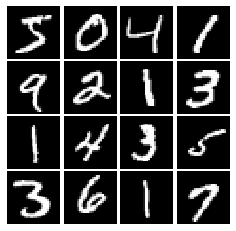

In [3]:
# show a batch
mnist = MNIST(batch_size=16) 
show_images(mnist.X[:16])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [4]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return tf.maximum(alpha * x, x)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


Test your leaky ReLU implementation. You should get errors < 1e-10

In [5]:
def test_leaky_relu(x, y_true):
    y = leaky_relu(tf.constant(x))
    print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [6]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return tf.random.uniform([batch_size, dim], minval=-1, maxval=1)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


Make sure noise is the correct shape and type:

In [7]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    z = sample_noise(batch_size, dim)
    # Check z has the correct shape
    assert z.get_shape().as_list() == [batch_size, dim]
    # Make sure z is a Tensor and not a numpy array
    assert isinstance(z, tf.Tensor)
    # Check that we get different noise for different evaluations
    z1 = sample_noise(batch_size, dim)
    z2 = sample_noise(batch_size, dim)
    assert not np.array_equal(z1, z2)
    # Check that we get the correct range
    assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
    print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. **Hint:** You should use the layers in `tf.keras.layers` to build the model.
All fully connected layers should include bias terms. For initialization, just use the default initializer used by the `tf.keras.layers` functions.

Architecture:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with output size 1 
 
The output of the discriminator should thus have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [8]:
def discriminator():
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    model = tf.keras.models.Sequential([
        # TODO: implement architecture
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        tf.keras.layers.Dense(256, input_shape=(784,)),
        tf.keras.layers.Activation(leaky_relu),
        tf.keras.layers.Dense(256),
        tf.keras.layers.Activation(leaky_relu),
        tf.keras.layers.Dense(1),

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ])
    return model

Test to make sure the number of parameters in the discriminator is correct:

In [9]:
def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
    else:
        print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.keras.layers` to construct the model. All fully connected layers should include bias terms. Note that you can use the tf.nn module to access activation functions. Once again, use the default initializers for parameters.

Architecture:
 * Fully connected layer with inupt size tf.shape(z)[1] (the number of noise dimensions) and output size 1024
 * `ReLU`
 * Fully connected layer with output size 1024 
 * `ReLU`
 * Fully connected layer with output size 784
 * `TanH` (To restrict every element of the output to be in the range [-1,1])

In [10]:
def generator(noise_dim=NOISE_DIM):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    model = tf.keras.models.Sequential([
        # TODO: implement architecture
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        tf.keras.layers.Dense(1024, input_shape=(noise_dim,)),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(1024),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(784),
        tf.keras.layers.Activation(tf.tanh),

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ])
    return model

Test to make sure the number of parameters in the generator is correct:

In [11]:
def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
    else:
        print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/ones) and [tf.zeros](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/zeros) to generate labels for your discriminator. Use [tf.keras.losses.BinaryCrossentropy](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/losses/BinaryCrossentropy) to help compute your loss function.

In [12]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: Tensor of shape (N, 1) giving scores for the real data.
    - logits_fake: Tensor of shape (N, 1) giving scores for the fake data.
    
    Returns:
    - loss: Tensor containing (scalar) the loss for the discriminator.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    bce = tf.losses.BinaryCrossentropy(from_logits=True)
    real_loss = bce(tf.ones_like(logits_real), logits_real)
    fake_loss = bce(tf.zeros_like(logits_fake), logits_fake)
    loss = tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    bce = tf.losses.BinaryCrossentropy(from_logits=True)
    loss = tf.reduce_mean(bce(tf.ones_like(logits_fake), logits_fake))

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-8.

In [13]:
def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(tf.constant(logits_real),
                                tf.constant(logits_fake))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
                        answers['d_loss_true'])

Maximum error in d_loss: 3.97058e-09


In [14]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(tf.constant(logits_fake))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

Maximum error in g_loss: 4.4518e-09


# Optimizing our loss
Make an `Adam` optimizer with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [15]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.optimizers.Adam with correct learning_rate and beta1
    - G_solver: instance of tf.optimizers.Adam with correct learning_rate and beta1
    """
    D_solver = None
    G_solver = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    D_solver = tf.optimizers.Adam(learning_rate=learning_rate, beta_1=beta1)
    G_solver = tf.optimizers.Adam(learning_rate=learning_rate, beta_1=beta1)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return D_solver, G_solver

# Training a GAN!
Well that wasn't so hard, was it? After the first epoch, you should see fuzzy outlines, clear shapes as you approach epoch 3, and decent shapes, about half of which will be sharp and clearly recognizable as we pass epoch 5. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [16]:
# a giant helper function
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss,\
              show_every=50, print_every=50, batch_size=128, num_epochs=10, noise_size=96):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - D: Discriminator model
    - G: Generator model
    - D_solver: an Optimizer for Discriminator
    - G_solver: an Optimizer for Generator
    - generator_loss: Generator loss
    - discriminator_loss: Discriminator loss
    Returns:
        Nothing
    """
    mnist = MNIST(batch_size=batch_size, shuffle=True)
    
    iter_count = 0
    for epoch in range(num_epochs):
        for (x, _) in mnist:
            with tf.GradientTape() as tape:
                real_data = x
                logits_real = D(preprocess_img(real_data))

                g_fake_seed = sample_noise(batch_size, noise_size)
                fake_images = G(g_fake_seed)
                logits_fake = D(tf.reshape(fake_images, [batch_size, 784]))

                d_total_error = discriminator_loss(logits_real, logits_fake)
                d_gradients = tape.gradient(d_total_error, D.trainable_variables)      
                D_solver.apply_gradients(zip(d_gradients, D.trainable_variables))
            
            with tf.GradientTape() as tape:
                g_fake_seed = sample_noise(batch_size, noise_size)
                fake_images = G(g_fake_seed)

                gen_logits_fake = D(tf.reshape(fake_images, [batch_size, 784]))
                g_error = generator_loss(gen_logits_fake)
                g_gradients = tape.gradient(g_error, G.trainable_variables)      
                G_solver.apply_gradients(zip(g_gradients, G.trainable_variables))

            if (iter_count % show_every == 0):
                print('Epoch: {}, Iter: {}, D: {:.4}, G:{:.4}'.format(epoch, iter_count,d_total_error,g_error))
                imgs_numpy = fake_images.numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
            iter_count += 1
    
    # random noise fed into our generator
    z = sample_noise(batch_size, noise_size)
    # generated images
    G_sample = G(z)
    print('Final images')
    show_images(G_sample[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or about 2 minutes on GPU.

Epoch: 0, Iter: 0, D: 1.404, G:0.7331


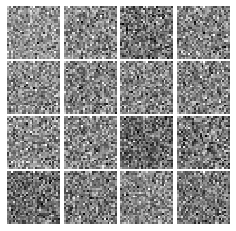

Epoch: 0, Iter: 50, D: 0.2433, G:1.805


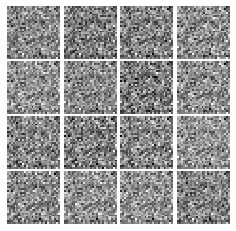

Epoch: 0, Iter: 100, D: 1.191, G:2.053


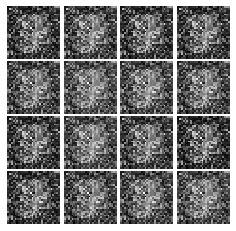

Epoch: 0, Iter: 150, D: 1.115, G:3.105


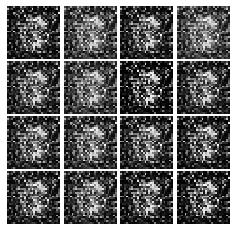

Epoch: 0, Iter: 200, D: 1.352, G:1.406


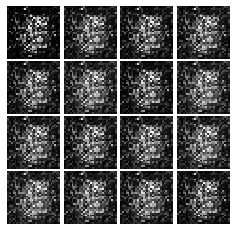

Epoch: 0, Iter: 250, D: 0.9536, G:1.902


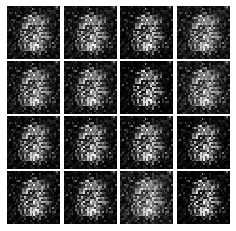

Epoch: 0, Iter: 300, D: 1.176, G:1.238


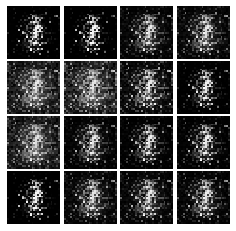

Epoch: 0, Iter: 350, D: 1.396, G:0.9094


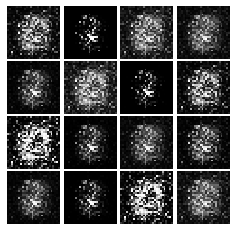

Epoch: 0, Iter: 400, D: 1.019, G:1.806


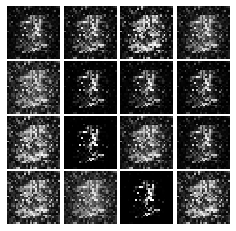

Epoch: 0, Iter: 450, D: 1.348, G:1.322


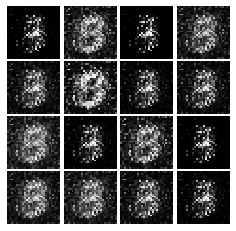

Epoch: 1, Iter: 500, D: 1.665, G:4.849


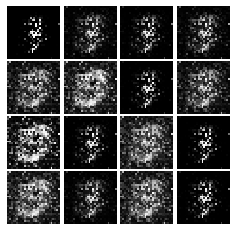

Epoch: 1, Iter: 550, D: 0.8967, G:1.813


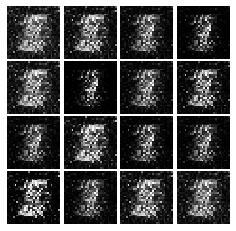

Epoch: 1, Iter: 600, D: 1.246, G:1.177


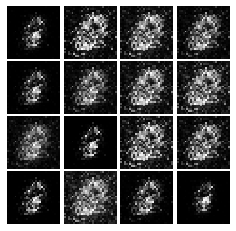

Epoch: 1, Iter: 650, D: 1.356, G:1.238


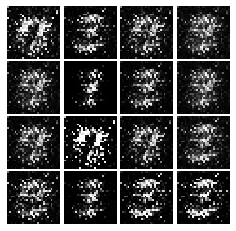

Epoch: 1, Iter: 700, D: 1.192, G:1.474


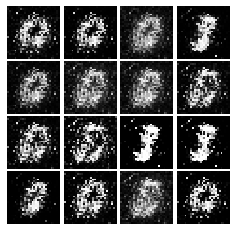

Epoch: 1, Iter: 750, D: 1.491, G:1.351


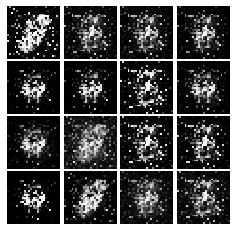

Epoch: 1, Iter: 800, D: 1.28, G:1.089


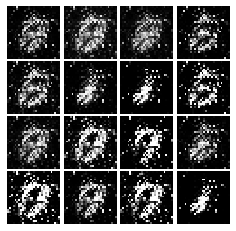

Epoch: 1, Iter: 850, D: 0.988, G:1.361


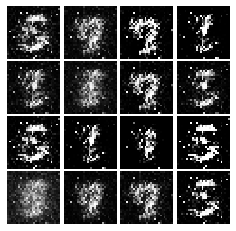

Epoch: 1, Iter: 900, D: 1.145, G:1.155


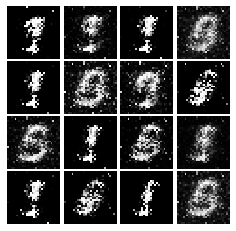

Epoch: 2, Iter: 950, D: 1.461, G:0.6341


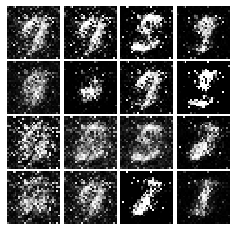

Epoch: 2, Iter: 1000, D: 1.157, G:1.197


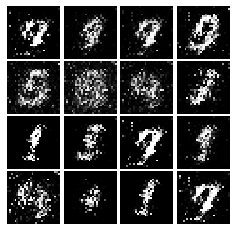

Epoch: 2, Iter: 1050, D: 1.242, G:1.091


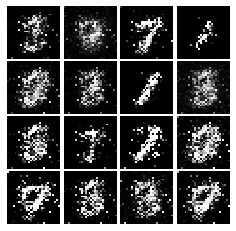

Epoch: 2, Iter: 1100, D: 1.276, G:1.344


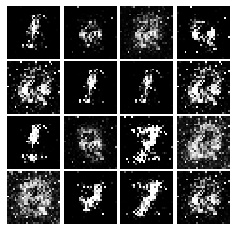

Epoch: 2, Iter: 1150, D: 0.9949, G:1.189


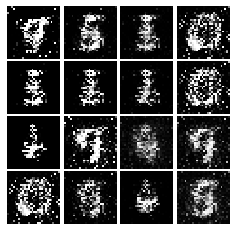

Epoch: 2, Iter: 1200, D: 1.13, G:1.005


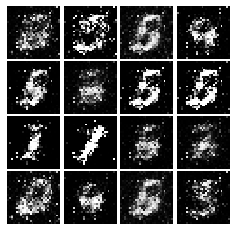

Epoch: 2, Iter: 1250, D: 1.677, G:0.6216


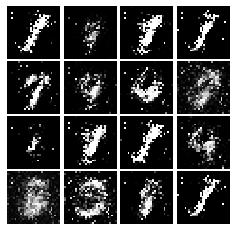

Epoch: 2, Iter: 1300, D: 1.314, G:0.9484


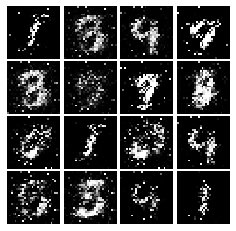

Epoch: 2, Iter: 1350, D: 2.127, G:0.9826


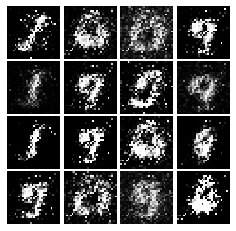

Epoch: 2, Iter: 1400, D: 0.981, G:1.468


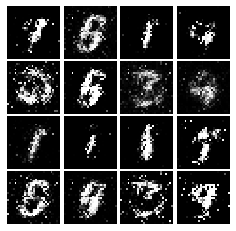

Epoch: 3, Iter: 1450, D: 1.178, G:1.119


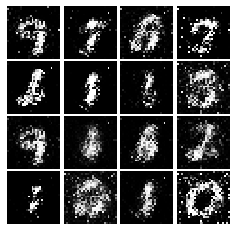

Epoch: 3, Iter: 1500, D: 1.202, G:1.198


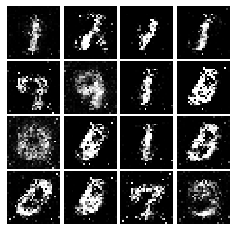

Epoch: 3, Iter: 1550, D: 1.185, G:0.8476


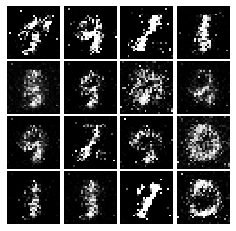

Epoch: 3, Iter: 1600, D: 1.253, G:0.8613


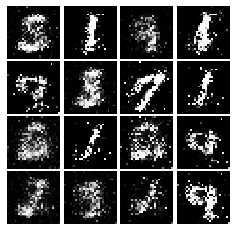

Epoch: 3, Iter: 1650, D: 1.353, G:0.8297


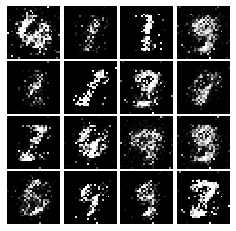

Epoch: 3, Iter: 1700, D: 1.341, G:0.7423


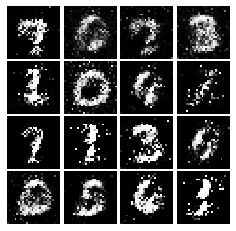

Epoch: 3, Iter: 1750, D: 1.419, G:0.97


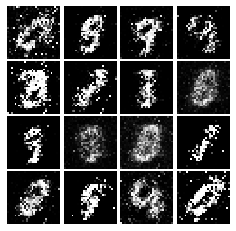

Epoch: 3, Iter: 1800, D: 1.43, G:0.7395


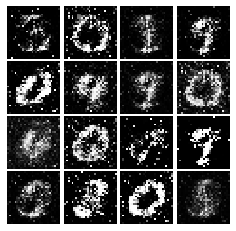

Epoch: 3, Iter: 1850, D: 1.26, G:1.013


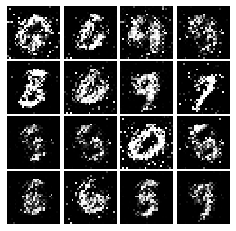

Epoch: 4, Iter: 1900, D: 1.338, G:0.9682


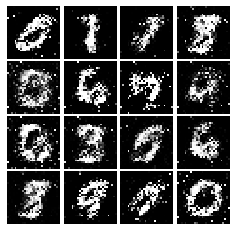

Epoch: 4, Iter: 1950, D: 1.22, G:1.095


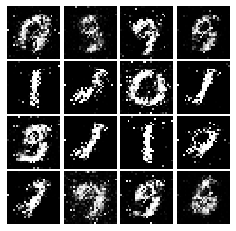

Epoch: 4, Iter: 2000, D: 1.266, G:0.8062


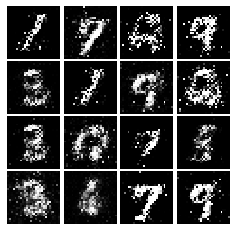

Epoch: 4, Iter: 2050, D: 1.421, G:0.7981


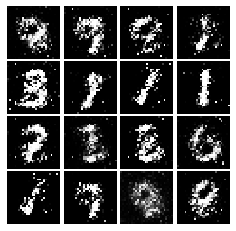

Epoch: 4, Iter: 2100, D: 1.278, G:0.8105


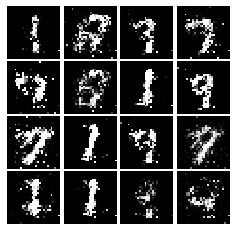

Epoch: 4, Iter: 2150, D: 1.311, G:0.9978


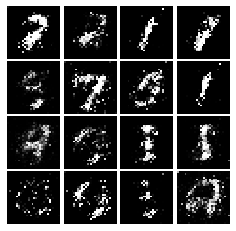

Epoch: 4, Iter: 2200, D: 1.244, G:0.9366


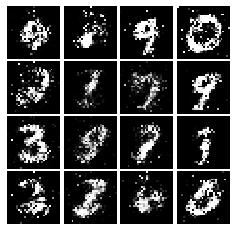

Epoch: 4, Iter: 2250, D: 1.345, G:0.7955


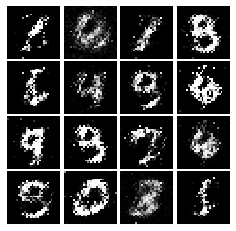

Epoch: 4, Iter: 2300, D: 1.283, G:0.8217


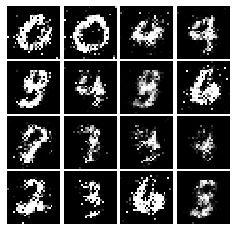

Epoch: 5, Iter: 2350, D: 1.279, G:0.9248


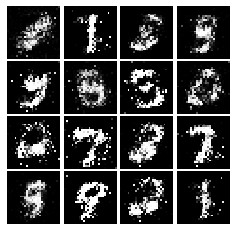

Epoch: 5, Iter: 2400, D: 1.546, G:0.3391


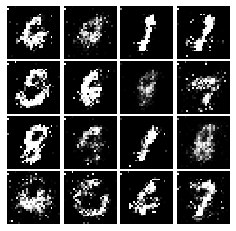

Epoch: 5, Iter: 2450, D: 1.37, G:0.7748


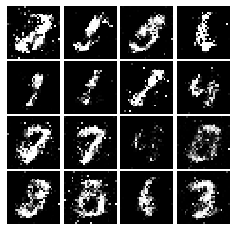

Epoch: 5, Iter: 2500, D: 1.145, G:1.028


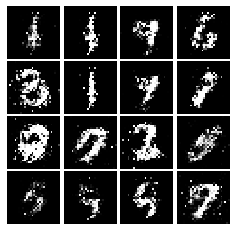

Epoch: 5, Iter: 2550, D: 1.355, G:0.7018


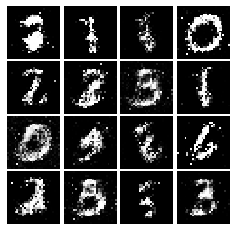

Epoch: 5, Iter: 2600, D: 1.466, G:0.6759


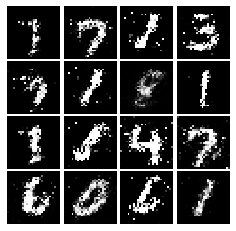

Epoch: 5, Iter: 2650, D: 1.34, G:0.8898


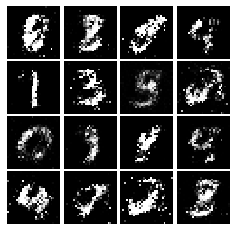

Epoch: 5, Iter: 2700, D: 1.311, G:0.8557


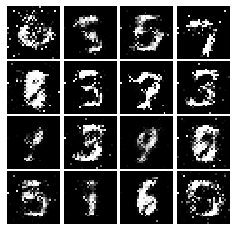

Epoch: 5, Iter: 2750, D: 1.443, G:0.8052


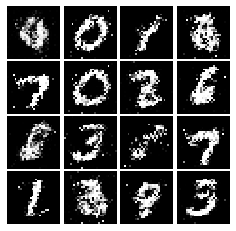

Epoch: 5, Iter: 2800, D: 1.262, G:0.8209


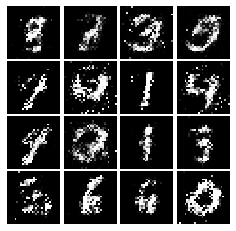

Epoch: 6, Iter: 2850, D: 1.347, G:0.7554


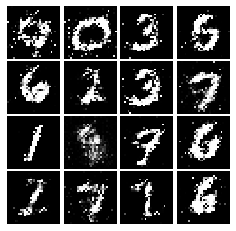

Epoch: 6, Iter: 2900, D: 1.285, G:0.8031


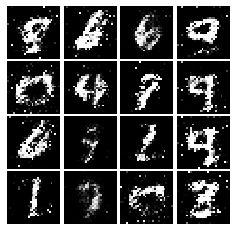

Epoch: 6, Iter: 2950, D: 1.265, G:0.9049


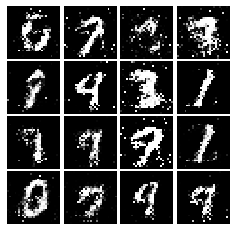

Epoch: 6, Iter: 3000, D: 1.382, G:0.8133


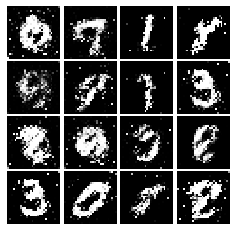

Epoch: 6, Iter: 3050, D: 1.537, G:1.254


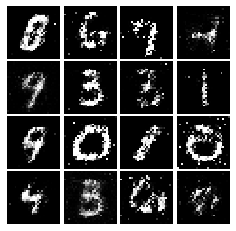

Epoch: 6, Iter: 3100, D: 1.331, G:0.7505


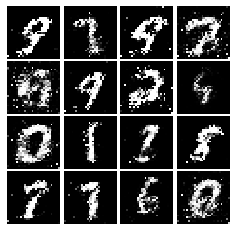

Epoch: 6, Iter: 3150, D: 1.421, G:0.7022


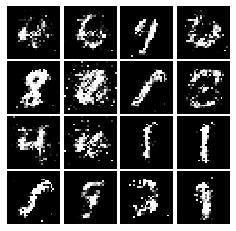

Epoch: 6, Iter: 3200, D: 1.257, G:1.073


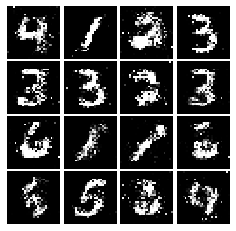

Epoch: 6, Iter: 3250, D: 1.347, G:0.8761


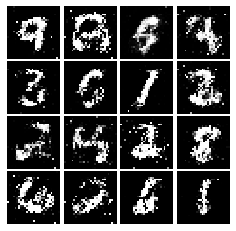

Epoch: 7, Iter: 3300, D: 1.284, G:0.8029


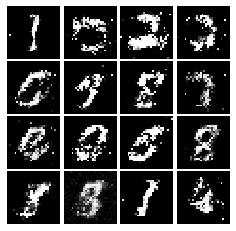

Epoch: 7, Iter: 3350, D: 1.155, G:1.077


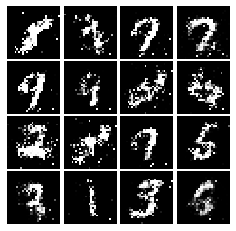

Epoch: 7, Iter: 3400, D: 1.323, G:0.8481


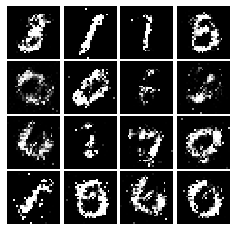

Epoch: 7, Iter: 3450, D: 1.28, G:0.8395


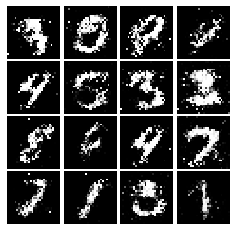

Epoch: 7, Iter: 3500, D: 1.312, G:0.8039


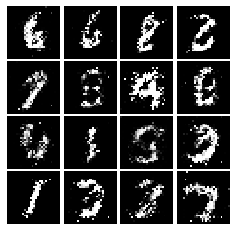

Epoch: 7, Iter: 3550, D: 1.3, G:0.8038


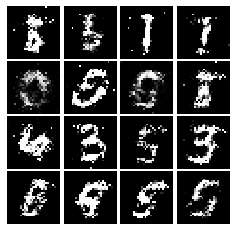

Epoch: 7, Iter: 3600, D: 1.321, G:0.9111


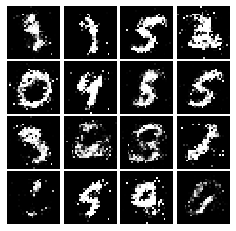

Epoch: 7, Iter: 3650, D: 1.402, G:0.7791


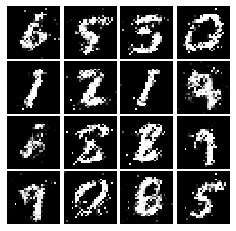

Epoch: 7, Iter: 3700, D: 1.339, G:0.8435


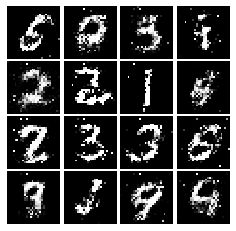

Epoch: 7, Iter: 3750, D: 1.255, G:0.8403


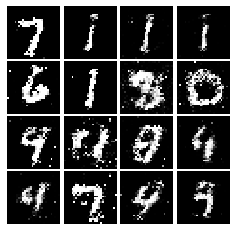

Epoch: 8, Iter: 3800, D: 1.349, G:0.7941


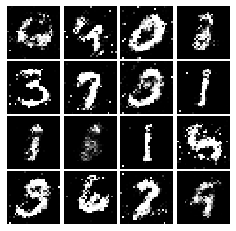

Epoch: 8, Iter: 3850, D: 1.281, G:0.8214


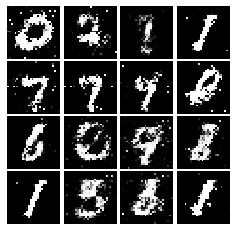

Epoch: 8, Iter: 3900, D: 1.376, G:0.7598


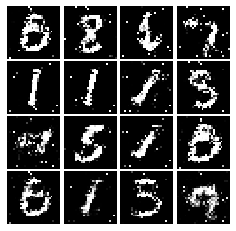

Epoch: 8, Iter: 3950, D: 1.284, G:0.7797


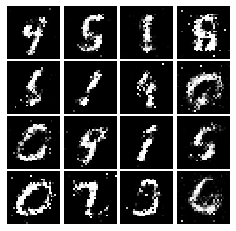

Epoch: 8, Iter: 4000, D: 1.217, G:0.77


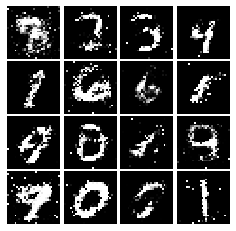

Epoch: 8, Iter: 4050, D: 1.27, G:0.8368


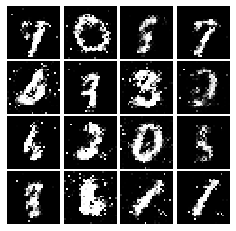

Epoch: 8, Iter: 4100, D: 1.41, G:0.9047


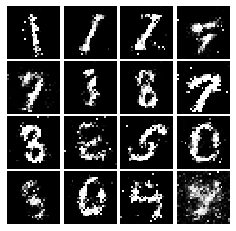

Epoch: 8, Iter: 4150, D: 1.4, G:0.8154


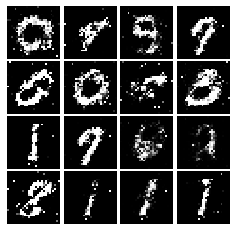

Epoch: 8, Iter: 4200, D: 1.361, G:0.755


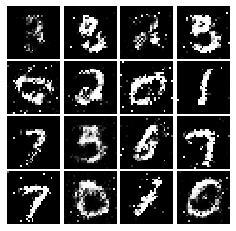

Epoch: 9, Iter: 4250, D: 1.352, G:0.7396


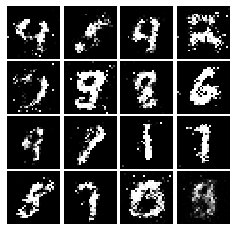

Epoch: 9, Iter: 4300, D: 1.32, G:0.7896


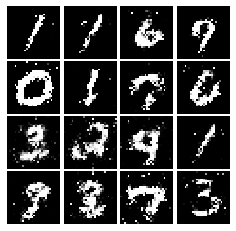

Epoch: 9, Iter: 4350, D: 1.384, G:0.7245


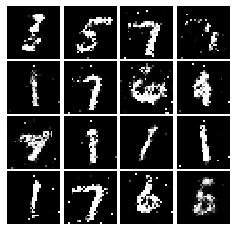

Epoch: 9, Iter: 4400, D: 1.213, G:0.8682


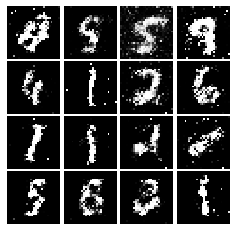

Epoch: 9, Iter: 4450, D: 1.34, G:0.8844


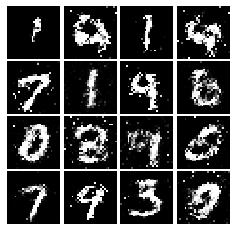

Epoch: 9, Iter: 4500, D: 1.521, G:0.8358


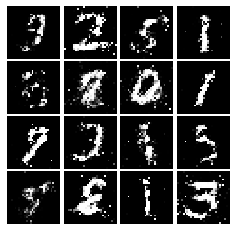

Epoch: 9, Iter: 4550, D: 1.352, G:0.7672


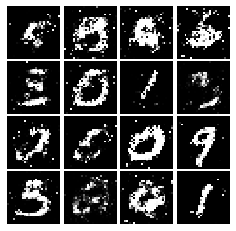

Epoch: 9, Iter: 4600, D: 1.299, G:0.7328


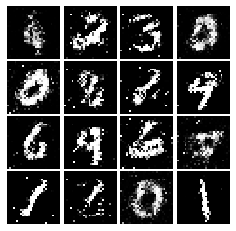

Epoch: 9, Iter: 4650, D: 1.335, G:0.7744


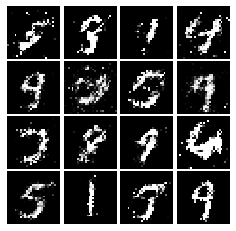

Final images


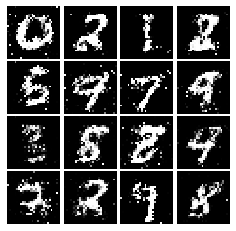

In [17]:
# Make the discriminator
D = discriminator()

# Make the generator
G = generator()

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver, G_solver = get_solvers()

# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [18]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.
    
    Inputs:
    - scores_real: Tensor of shape (N, 1) giving scores for the real data.
    - scores_fake: Tensor of shape (N, 1) giving scores for the fake data.
    
    Outputs:
    - loss: A Tensor containing the loss.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    loss = (tf.reduce_mean((scores_real - 1) ** 2) + tf.reduce_mean(scores_fake ** 2)) / 2

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
    
    Inputs:
    - scores_fake: Tensor of shape (N, 1) giving scores for the fake data.
    
    Outputs:
    - loss: A Tensor containing the loss.
    """
    loss = None
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    loss = tf.reduce_mean((scores_fake - 1) ** 2) / 2

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss

Test your LSGAN loss. You should see errors less than 1e-8.

In [19]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    
    d_loss = ls_discriminator_loss(tf.constant(score_real), tf.constant(score_fake))
    g_loss = ls_generator_loss(tf.constant(score_fake))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

Epoch: 0, Iter: 0, D: 0.08165, G:0.5225


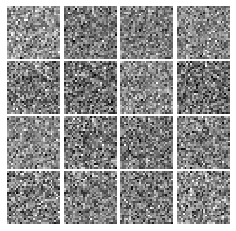

Epoch: 0, Iter: 50, D: 0.01235, G:0.5411


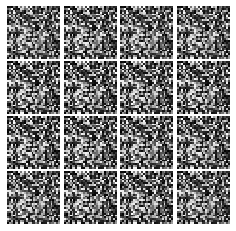

Epoch: 0, Iter: 100, D: 0.0248, G:0.9749


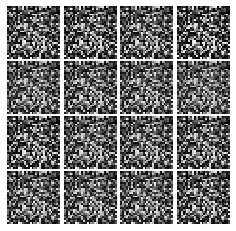

Epoch: 0, Iter: 150, D: 0.06335, G:0.2815


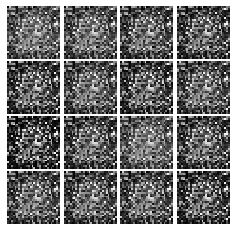

Epoch: 0, Iter: 200, D: 0.2611, G:0.5157


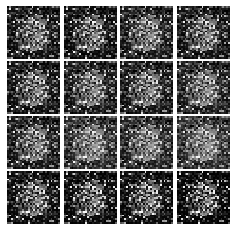

Epoch: 0, Iter: 250, D: 0.1413, G:0.3961


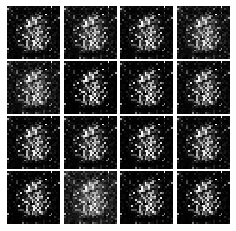

Epoch: 0, Iter: 300, D: 0.3401, G:0.007869


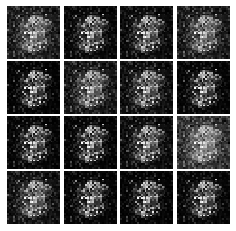

Epoch: 0, Iter: 350, D: 0.1702, G:0.4055


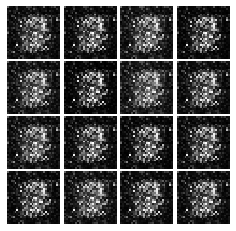

Epoch: 0, Iter: 400, D: 0.1826, G:0.4561


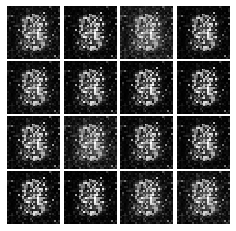

Epoch: 0, Iter: 450, D: 0.2681, G:0.2807


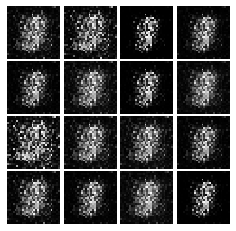

Epoch: 1, Iter: 500, D: 0.1715, G:0.5214


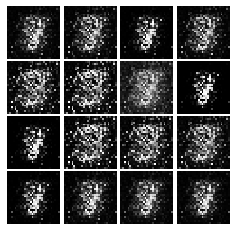

Epoch: 1, Iter: 550, D: 0.08876, G:0.39


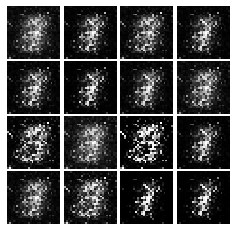

Epoch: 1, Iter: 600, D: 0.1375, G:0.3245


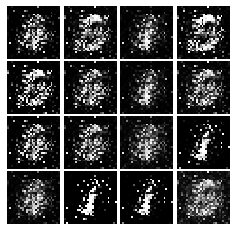

Epoch: 1, Iter: 650, D: 0.1855, G:0.3447


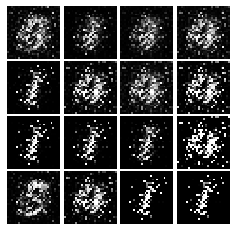

Epoch: 1, Iter: 700, D: 0.1408, G:0.4465


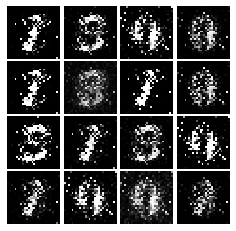

Epoch: 1, Iter: 750, D: 0.1157, G:0.7291


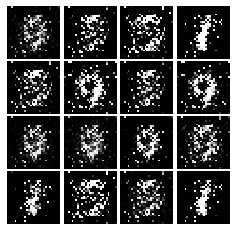

Epoch: 1, Iter: 800, D: 0.1529, G:0.1377


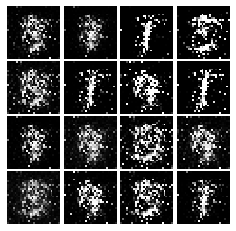

Epoch: 1, Iter: 850, D: 0.1452, G:0.6011


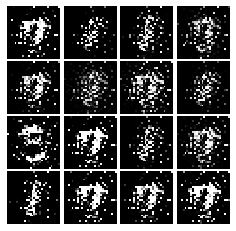

Epoch: 1, Iter: 900, D: 0.1443, G:0.3393


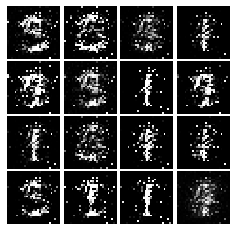

Epoch: 2, Iter: 950, D: 0.3341, G:0.3078


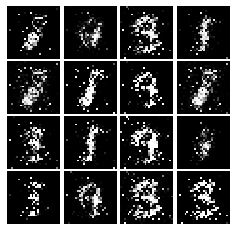

Epoch: 2, Iter: 1000, D: 0.1102, G:0.5212


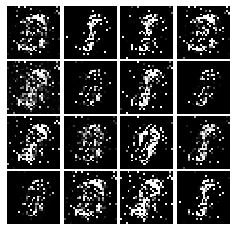

Epoch: 2, Iter: 1050, D: 0.2026, G:0.04943


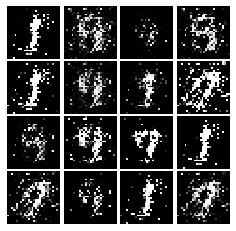

Epoch: 2, Iter: 1100, D: 0.09576, G:0.3797


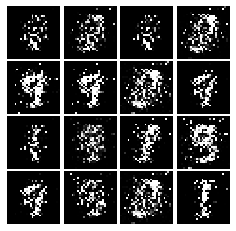

Epoch: 2, Iter: 1150, D: 0.07923, G:0.4128


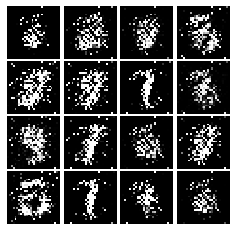

Epoch: 2, Iter: 1200, D: 0.1173, G:0.419


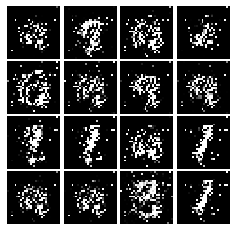

Epoch: 2, Iter: 1250, D: 0.09922, G:0.4143


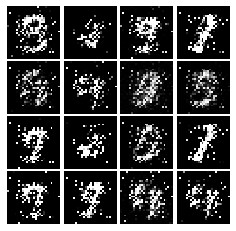

Epoch: 2, Iter: 1300, D: 0.1639, G:0.2854


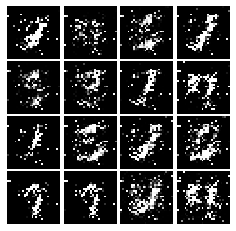

Epoch: 2, Iter: 1350, D: 0.1411, G:0.4775


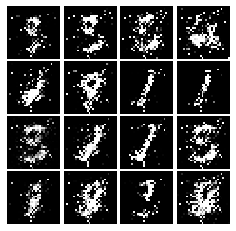

Epoch: 2, Iter: 1400, D: 0.1273, G:0.3269


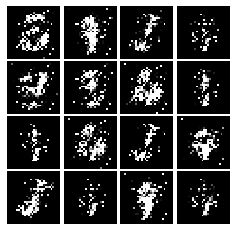

Epoch: 3, Iter: 1450, D: 0.07075, G:0.2876


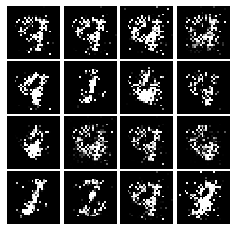

Epoch: 3, Iter: 1500, D: 0.1659, G:0.1761


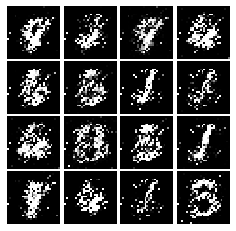

Epoch: 3, Iter: 1550, D: 0.1298, G:0.2901


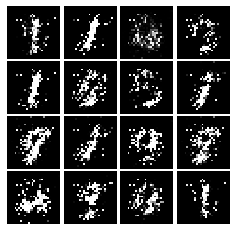

Epoch: 3, Iter: 1600, D: 0.1634, G:0.2534


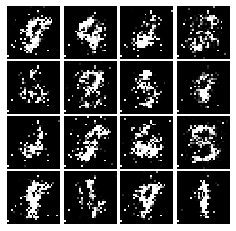

Epoch: 3, Iter: 1650, D: 0.1724, G:0.2232


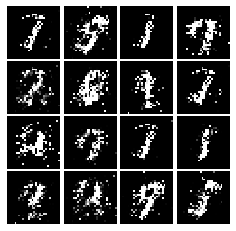

Epoch: 3, Iter: 1700, D: 0.1653, G:0.2642


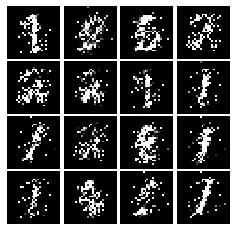

Epoch: 3, Iter: 1750, D: 0.1443, G:0.3148


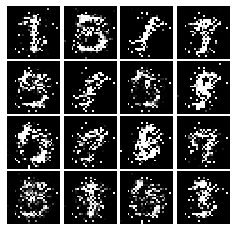

Epoch: 3, Iter: 1800, D: 0.1425, G:0.2662


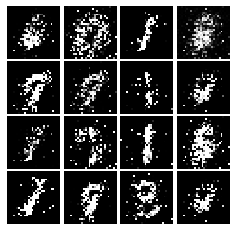

Epoch: 3, Iter: 1850, D: 0.1539, G:0.2468


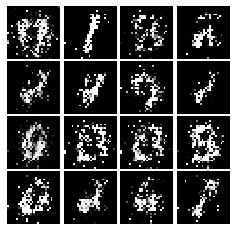

Epoch: 4, Iter: 1900, D: 0.175, G:0.5511


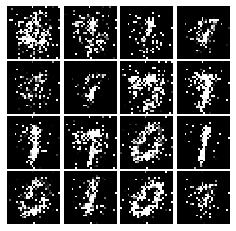

Epoch: 4, Iter: 1950, D: 0.1843, G:0.2378


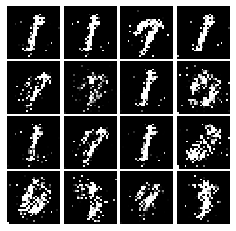

Epoch: 4, Iter: 2000, D: 0.2015, G:0.3497


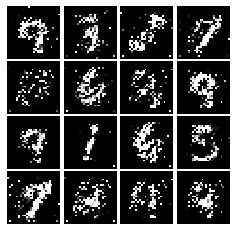

Epoch: 4, Iter: 2050, D: 0.2192, G:0.3121


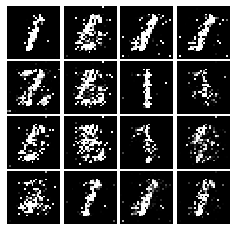

Epoch: 4, Iter: 2100, D: 0.2006, G:0.1748


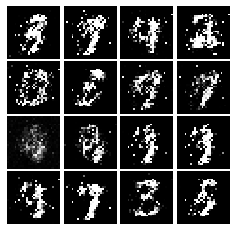

Epoch: 4, Iter: 2150, D: 0.1876, G:0.2206


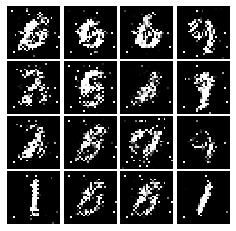

Epoch: 4, Iter: 2200, D: 0.2115, G:0.2212


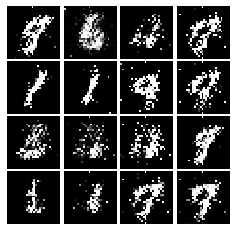

Epoch: 4, Iter: 2250, D: 0.2343, G:0.1943


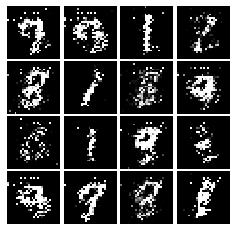

Epoch: 4, Iter: 2300, D: 0.1962, G:0.2007


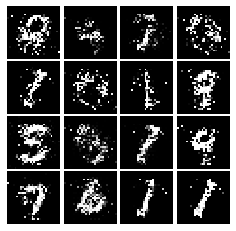

Epoch: 5, Iter: 2350, D: 0.2166, G:0.1857


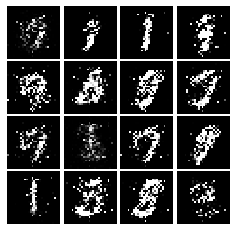

Epoch: 5, Iter: 2400, D: 0.2282, G:0.1528


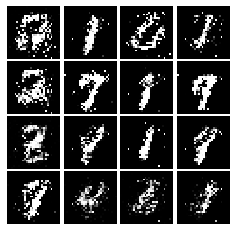

Epoch: 5, Iter: 2450, D: 0.1916, G:0.1963


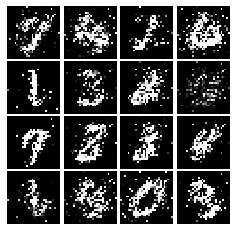

Epoch: 5, Iter: 2500, D: 0.1959, G:0.2148


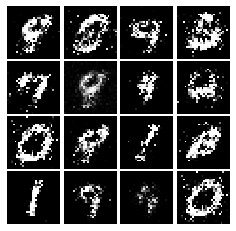

Epoch: 5, Iter: 2550, D: 0.2258, G:0.1935


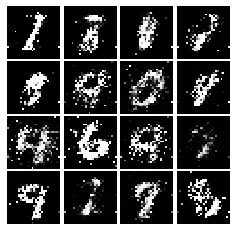

Epoch: 5, Iter: 2600, D: 0.2601, G:0.1834


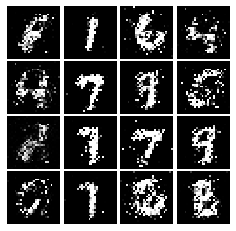

Epoch: 5, Iter: 2650, D: 0.2, G:0.1938


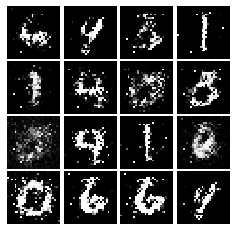

Epoch: 5, Iter: 2700, D: 0.2228, G:0.1765


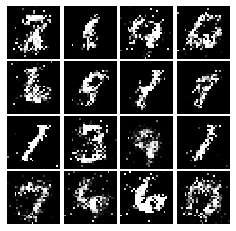

Epoch: 5, Iter: 2750, D: 0.214, G:0.2607


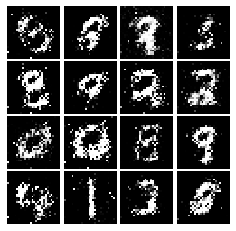

Epoch: 5, Iter: 2800, D: 0.2215, G:0.1516


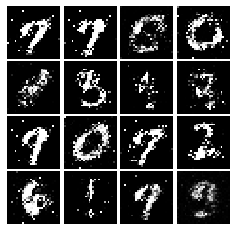

Epoch: 6, Iter: 2850, D: 0.2186, G:0.2084


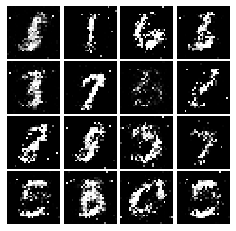

Epoch: 6, Iter: 2900, D: 0.2129, G:0.1697


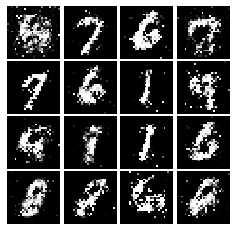

Epoch: 6, Iter: 2950, D: 0.205, G:0.1982


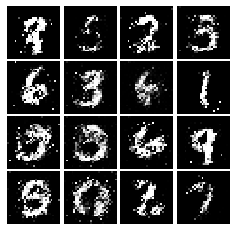

Epoch: 6, Iter: 3000, D: 0.2297, G:0.161


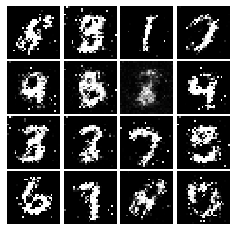

Epoch: 6, Iter: 3050, D: 0.2449, G:0.1532


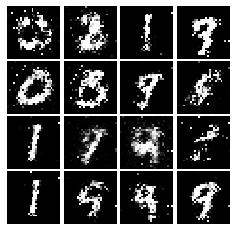

Epoch: 6, Iter: 3100, D: 0.2355, G:0.1743


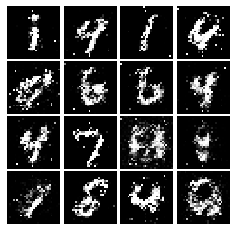

Epoch: 6, Iter: 3150, D: 0.2355, G:0.1842


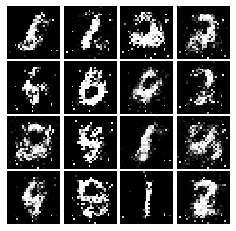

Epoch: 6, Iter: 3200, D: 0.2384, G:0.1645


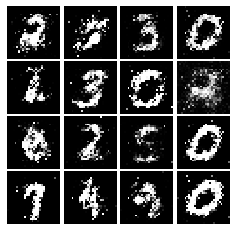

Epoch: 6, Iter: 3250, D: 0.2375, G:0.15


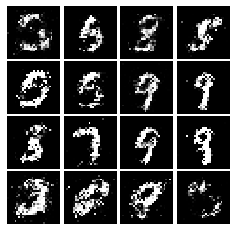

Epoch: 7, Iter: 3300, D: 0.2344, G:0.1918


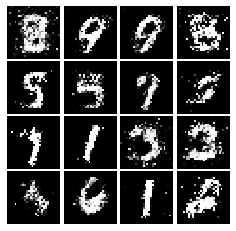

Epoch: 7, Iter: 3350, D: 0.2241, G:0.1642


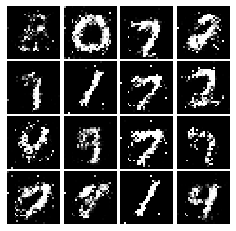

Epoch: 7, Iter: 3400, D: 0.2521, G:0.1963


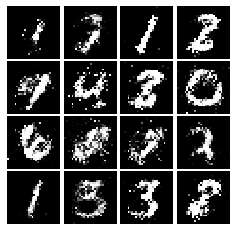

Epoch: 7, Iter: 3450, D: 0.2351, G:0.164


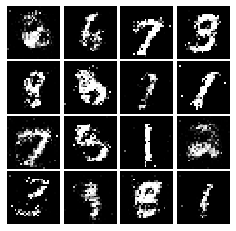

Epoch: 7, Iter: 3500, D: 0.2343, G:0.1772


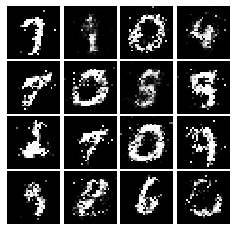

Epoch: 7, Iter: 3550, D: 0.2382, G:0.1876


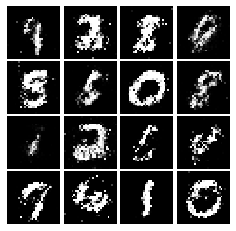

Epoch: 7, Iter: 3600, D: 0.2251, G:0.1488


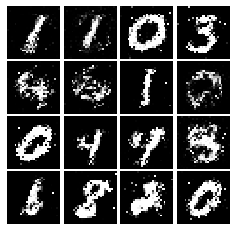

Epoch: 7, Iter: 3650, D: 0.2479, G:0.1636


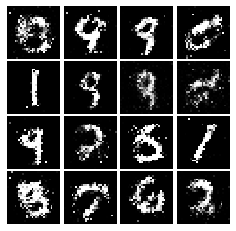

Epoch: 7, Iter: 3700, D: 0.2267, G:0.1692


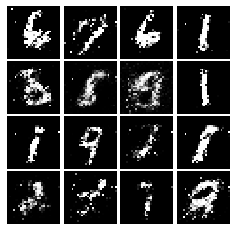

Epoch: 7, Iter: 3750, D: 0.2285, G:0.1575


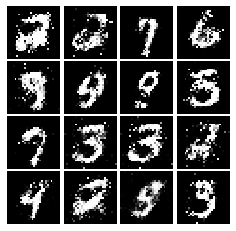

Epoch: 8, Iter: 3800, D: 0.2357, G:0.1796


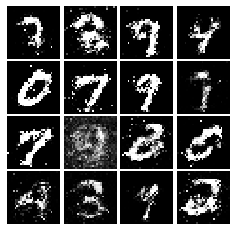

Epoch: 8, Iter: 3850, D: 0.2022, G:0.1795


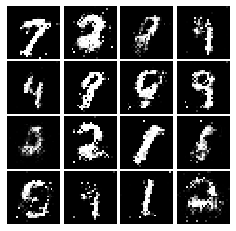

Epoch: 8, Iter: 3900, D: 0.2405, G:0.1808


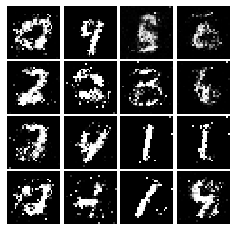

Epoch: 8, Iter: 3950, D: 0.2262, G:0.1716


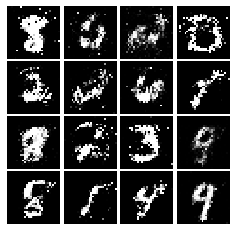

Epoch: 8, Iter: 4000, D: 0.2049, G:0.1679


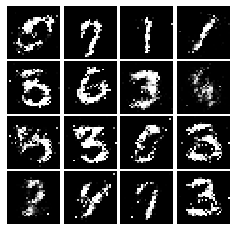

Epoch: 8, Iter: 4050, D: 0.2321, G:0.185


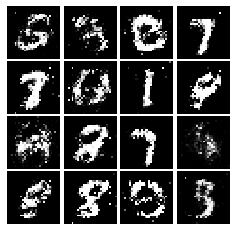

Epoch: 8, Iter: 4100, D: 0.2489, G:0.1553


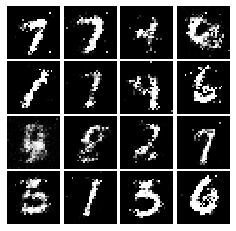

Epoch: 8, Iter: 4150, D: 0.2237, G:0.1938


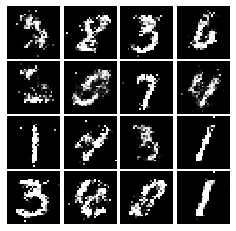

Epoch: 8, Iter: 4200, D: 0.2179, G:0.1868


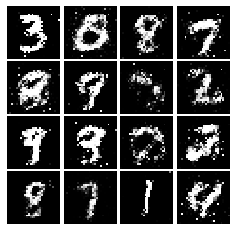

Epoch: 9, Iter: 4250, D: 0.2464, G:0.1446


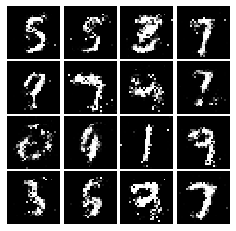

Epoch: 9, Iter: 4300, D: 0.2799, G:0.1795


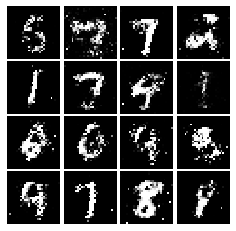

Epoch: 9, Iter: 4350, D: 0.2532, G:0.1661


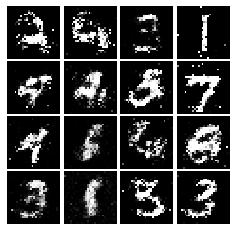

Epoch: 9, Iter: 4400, D: 0.2165, G:0.168


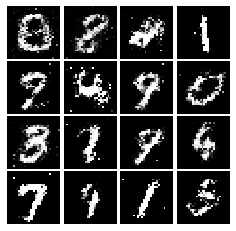

Epoch: 9, Iter: 4450, D: 0.2411, G:0.1555


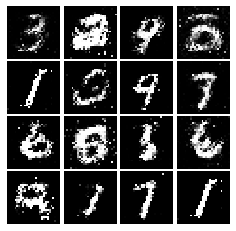

Epoch: 9, Iter: 4500, D: 0.2477, G:0.1692


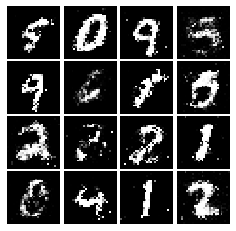

Epoch: 9, Iter: 4550, D: 0.2334, G:0.1834


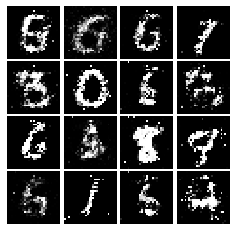

Epoch: 9, Iter: 4600, D: 0.2356, G:0.1784


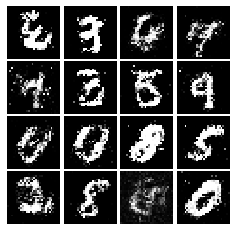

Epoch: 9, Iter: 4650, D: 0.26, G:0.1592


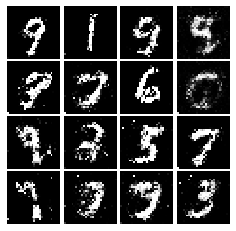

Final images


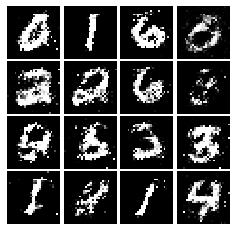

In [20]:
# Make the discriminator
D = discriminator()

# Make the generator
G = generator()

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver, G_solver = get_solvers()

# Run it!
run_a_gan(D, G, D_solver, G_solver, ls_discriminator_loss, ls_generator_loss)

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. Please use `tf.keras.layers` to define the following architecture:

Architecture:
* Conv2D: 32 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

Once again, please use biases for all convolutional and fully connected layers, and use the default parameter initializers. Note that a padding of 0 can be accomplished with the 'VALID' padding option.

In [21]:
def discriminator():
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """

    model = tf.keras.models.Sequential([
        # TODO: implement architecture
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        tf.keras.layers.Reshape((28, 28, 1), input_shape=(784,)),
        tf.keras.layers.Conv2D(32, 5),
        tf.keras.layers.Activation(leaky_relu),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(64, 5),
        tf.keras.layers.Activation(leaky_relu),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4 * 4 * 64),
        tf.keras.layers.Activation(leaky_relu),
        tf.keras.layers.Dense(1),

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ])

    return model

model = discriminator()
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. Please use `tf.keras.layers` for your implementation. You might find the documentation for [tf.keras.layers.Conv2DTranspose](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Conv2DTranspose) useful. The architecture is as follows.

Architecture:
* Fully connected with output size 1024 
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* `ReLU`
* BatchNorm
* Resize into Image Tensor of size 7, 7, 128
* Conv2D^T (transpose): 64 filters of 4x4, stride 2
* `ReLU`
* BatchNorm
* Conv2d^T (transpose): 1 filter of 4x4, stride 2
* `TanH`

Once again, use biases for the fully connected and transpose convolutional layers. Please use the default initializers for your parameters. For padding, choose the 'same' option for transpose convolutions. For Batch Normalization, assume we are always in 'training' mode.

In [22]:
def generator(noise_dim=NOISE_DIM):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    model = tf.keras.models.Sequential()
    # TODO: implement architecture
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    model.add(tf.keras.layers.Dense(1024, input_shape=(noise_dim,)))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(7 * 7 * 128))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Reshape((7, 7, 128)))
    model.add(tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding="same"))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding="same"))
    model.add(tf.keras.layers.Activation(tf.tanh))

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return model
test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

Epoch: 0, Iter: 0, D: 1.445, G:0.6519


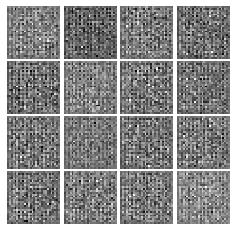

Epoch: 0, Iter: 50, D: 0.01848, G:4.182


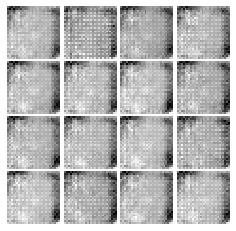

Epoch: 0, Iter: 100, D: 0.114, G:4.092


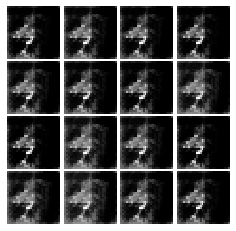

Epoch: 0, Iter: 150, D: 0.1179, G:3.356


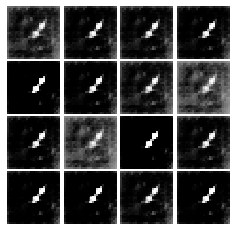

Epoch: 0, Iter: 200, D: 0.5536, G:3.221


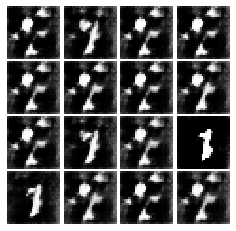

Epoch: 0, Iter: 250, D: 2.357, G:1.2


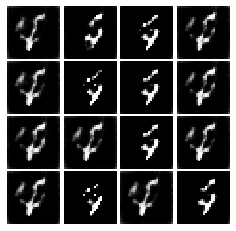

Epoch: 0, Iter: 300, D: 0.7348, G:3.01


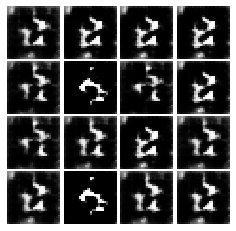

Epoch: 0, Iter: 350, D: 0.449, G:3.867


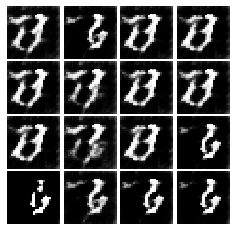

Epoch: 0, Iter: 400, D: 1.229, G:3.154


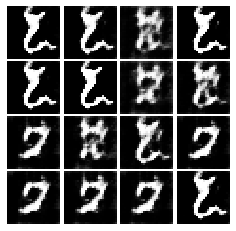

Epoch: 0, Iter: 450, D: 0.2088, G:3.065


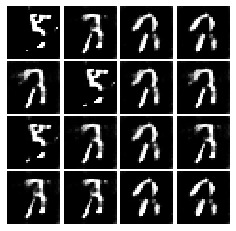

Epoch: 1, Iter: 500, D: 0.3356, G:2.949


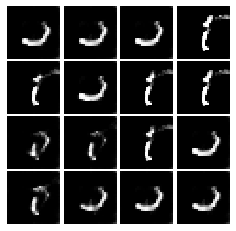

Epoch: 1, Iter: 550, D: 0.5712, G:3.351


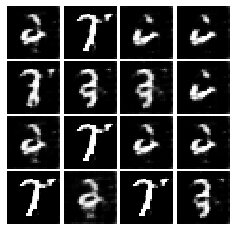

Epoch: 1, Iter: 600, D: 0.2277, G:2.847


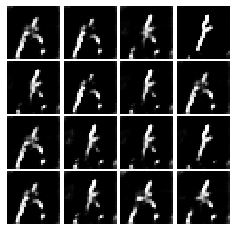

Epoch: 1, Iter: 650, D: 0.404, G:2.458


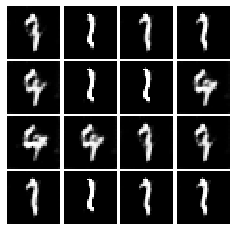

Epoch: 1, Iter: 700, D: 0.5344, G:3.528


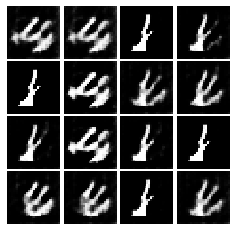

Epoch: 1, Iter: 750, D: 0.3074, G:3.68


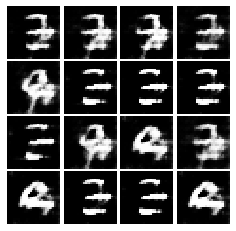

Epoch: 1, Iter: 800, D: 0.1985, G:3.727


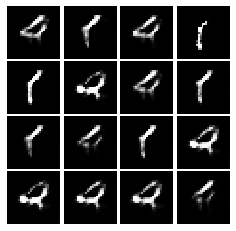

Epoch: 1, Iter: 850, D: 1.004, G:7.26


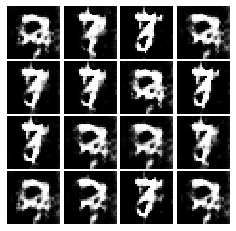

Epoch: 1, Iter: 900, D: 0.3209, G:3.571


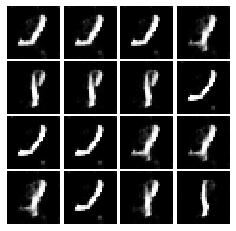

Epoch: 2, Iter: 950, D: 0.516, G:3.956


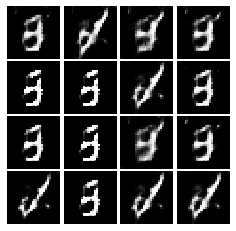

Epoch: 2, Iter: 1000, D: 0.3976, G:4.051


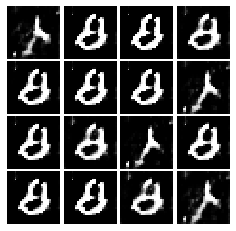

Epoch: 2, Iter: 1050, D: 0.08701, G:4.487


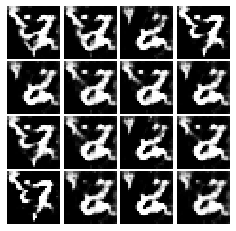

Epoch: 2, Iter: 1100, D: 0.313, G:3.317


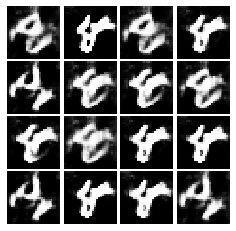

Epoch: 2, Iter: 1150, D: 0.29, G:3.201


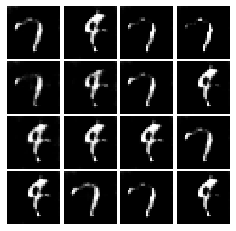

Epoch: 2, Iter: 1200, D: 0.3462, G:3.449


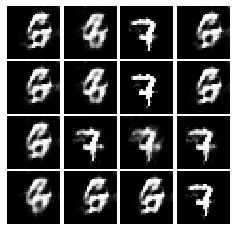

Epoch: 2, Iter: 1250, D: 0.8314, G:3.037


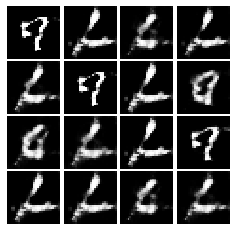

Epoch: 2, Iter: 1300, D: 0.2111, G:4.419


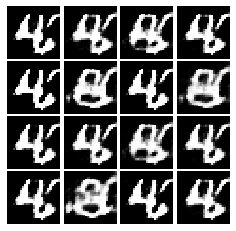

Epoch: 2, Iter: 1350, D: 0.1121, G:3.918


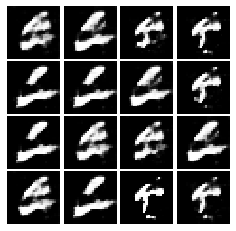

Epoch: 2, Iter: 1400, D: 0.6281, G:3.684


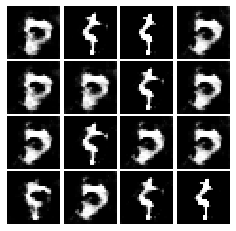

Epoch: 3, Iter: 1450, D: 0.6873, G:7.077


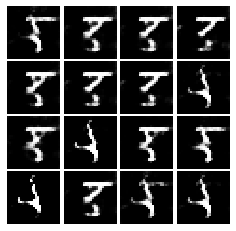

Epoch: 3, Iter: 1500, D: 0.1807, G:4.532


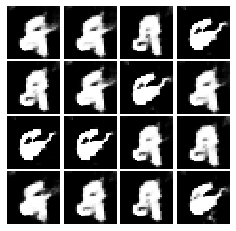

Epoch: 3, Iter: 1550, D: 0.2884, G:4.077


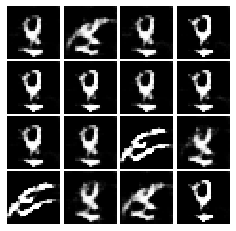

Epoch: 3, Iter: 1600, D: 0.2507, G:3.921


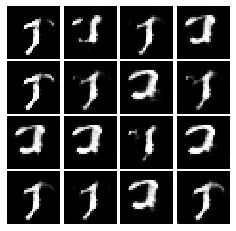

Epoch: 3, Iter: 1650, D: 0.1074, G:3.993


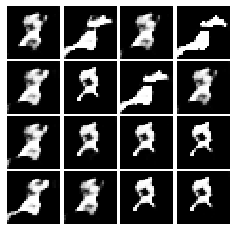

Epoch: 3, Iter: 1700, D: 0.3437, G:4.417


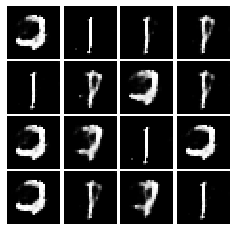

Epoch: 3, Iter: 1750, D: 0.2981, G:5.862


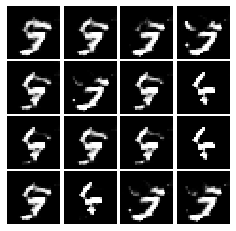

Epoch: 3, Iter: 1800, D: 1.84, G:6.853


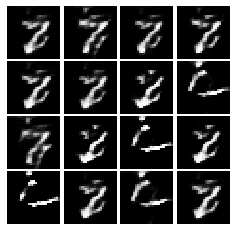

Epoch: 3, Iter: 1850, D: 0.2074, G:4.006


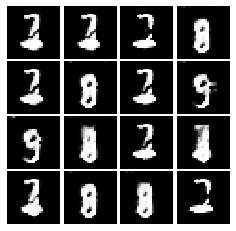

Epoch: 4, Iter: 1900, D: 0.04886, G:5.587


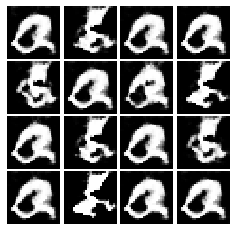

Epoch: 4, Iter: 1950, D: 0.9147, G:2.342


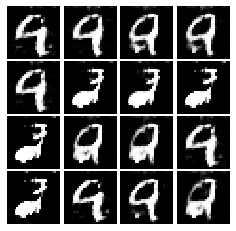

Epoch: 4, Iter: 2000, D: 0.4142, G:2.888


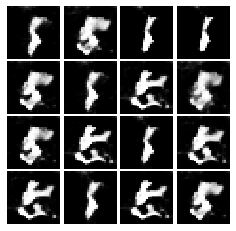

Epoch: 4, Iter: 2050, D: 0.3224, G:4.71


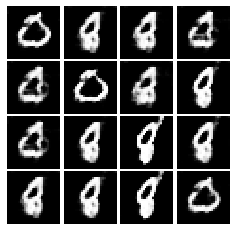

Epoch: 4, Iter: 2100, D: 0.1751, G:4.775


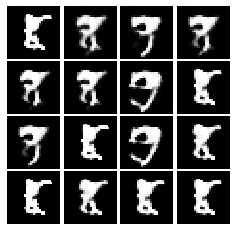

Epoch: 4, Iter: 2150, D: 0.2531, G:4.456


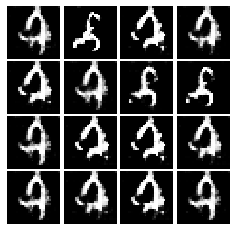

Epoch: 4, Iter: 2200, D: 0.7029, G:2.712


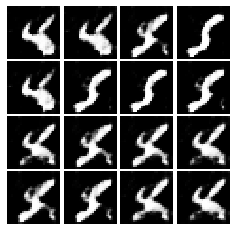

Epoch: 4, Iter: 2250, D: 0.6383, G:9.063


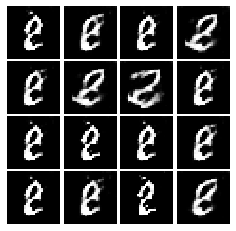

Epoch: 4, Iter: 2300, D: 0.9681, G:7.317


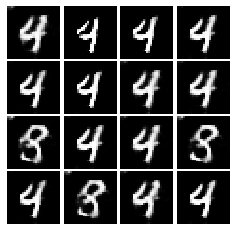

Epoch: 5, Iter: 2350, D: 0.2461, G:3.394


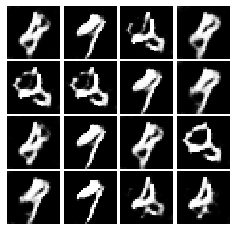

Epoch: 5, Iter: 2400, D: 0.5965, G:5.946


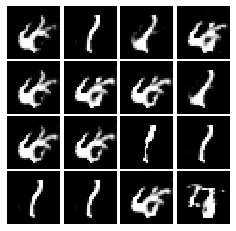

Epoch: 5, Iter: 2450, D: 0.2891, G:4.87


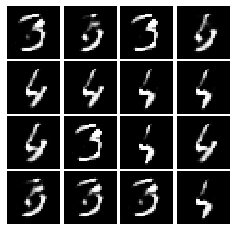

Epoch: 5, Iter: 2500, D: 0.2648, G:4.29


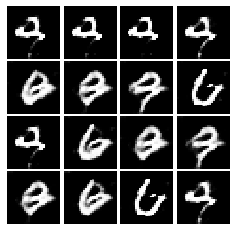

Epoch: 5, Iter: 2550, D: 0.5272, G:6.291


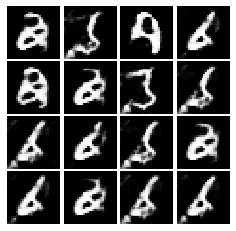

Epoch: 5, Iter: 2600, D: 0.1864, G:4.311


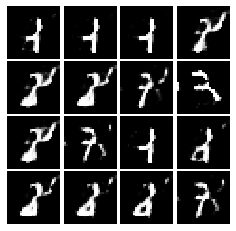

Epoch: 5, Iter: 2650, D: 0.2432, G:5.401


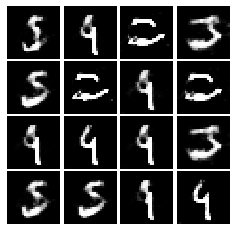

Epoch: 5, Iter: 2700, D: 0.3444, G:4.855


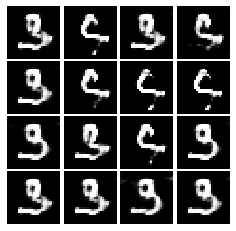

Epoch: 5, Iter: 2750, D: 0.2, G:3.475


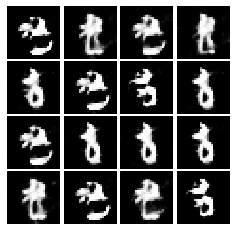

Epoch: 5, Iter: 2800, D: 0.1482, G:3.828


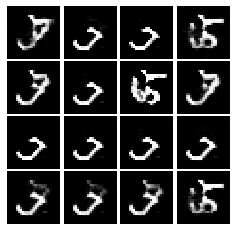

Epoch: 6, Iter: 2850, D: 0.1196, G:3.689


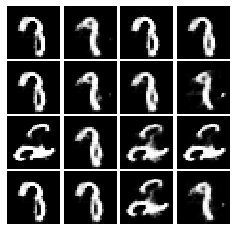

Epoch: 6, Iter: 2900, D: 0.09477, G:4.369


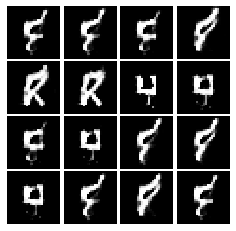

Epoch: 6, Iter: 2950, D: 0.2231, G:3.422


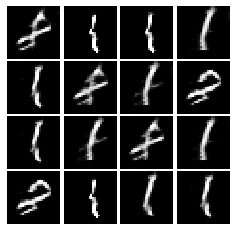

Epoch: 6, Iter: 3000, D: 0.1707, G:4.01


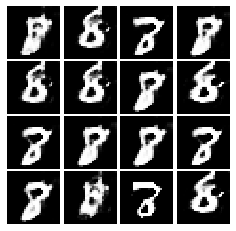

Epoch: 6, Iter: 3050, D: 0.2928, G:4.529


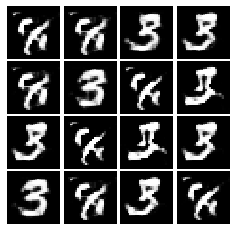

Epoch: 6, Iter: 3100, D: 0.3761, G:4.124


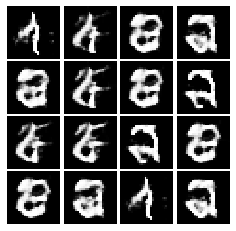

Epoch: 6, Iter: 3150, D: 0.5041, G:3.218


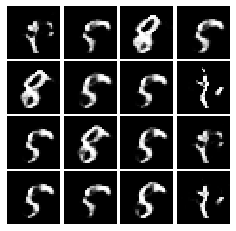

Epoch: 6, Iter: 3200, D: 0.4401, G:3.636


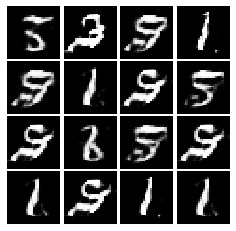

Epoch: 6, Iter: 3250, D: 0.1981, G:3.826


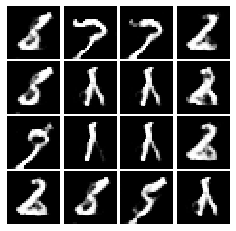

Epoch: 7, Iter: 3300, D: 0.1112, G:4.427


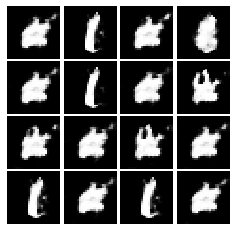

Epoch: 7, Iter: 3350, D: 0.47, G:6.658


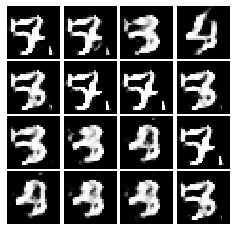

Epoch: 7, Iter: 3400, D: 0.2019, G:6.205


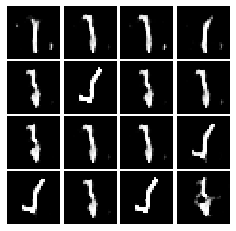

Epoch: 7, Iter: 3450, D: 0.4473, G:4.534


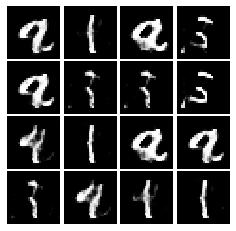

Epoch: 7, Iter: 3500, D: 0.3175, G:3.782


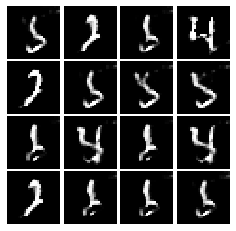

Epoch: 7, Iter: 3550, D: 0.0436, G:4.551


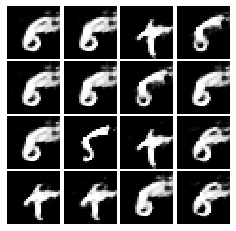

Epoch: 7, Iter: 3600, D: 0.1865, G:3.667


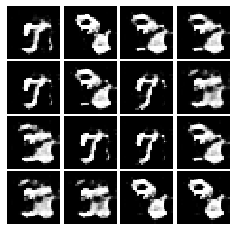

Epoch: 7, Iter: 3650, D: 0.294, G:4.813


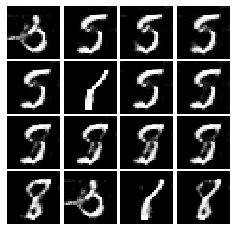

Epoch: 7, Iter: 3700, D: 0.4361, G:2.238


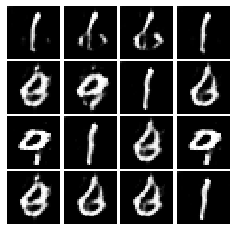

Epoch: 7, Iter: 3750, D: 0.301, G:4.356


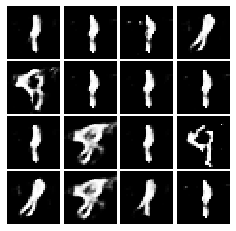

Epoch: 8, Iter: 3800, D: 1.58, G:3.51


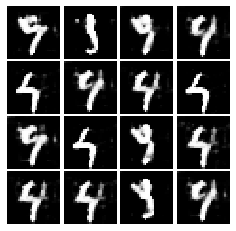

Epoch: 8, Iter: 3850, D: 0.2168, G:4.289


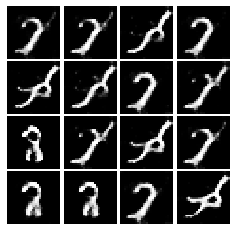

Epoch: 8, Iter: 3900, D: 0.1831, G:4.65


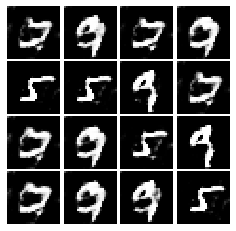

Epoch: 8, Iter: 3950, D: 0.278, G:1.837


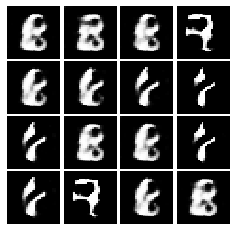

Epoch: 8, Iter: 4000, D: 0.3486, G:4.095


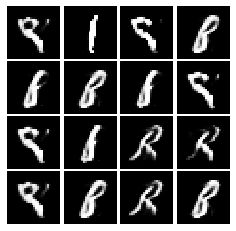

Epoch: 8, Iter: 4050, D: 0.3486, G:4.314


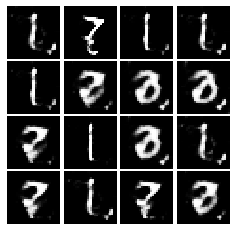

Epoch: 8, Iter: 4100, D: 0.4649, G:3.012


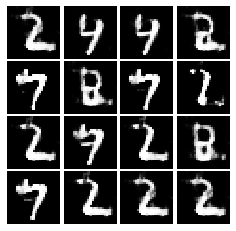

Epoch: 8, Iter: 4150, D: 0.2912, G:7.291


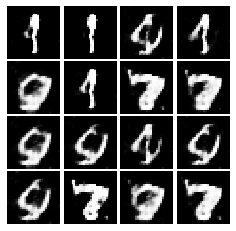

Epoch: 8, Iter: 4200, D: 0.1366, G:3.822


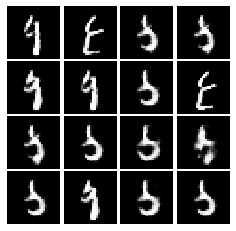

Epoch: 9, Iter: 4250, D: 0.217, G:4.957


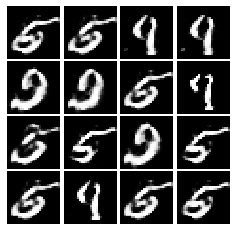

Epoch: 9, Iter: 4300, D: 0.3986, G:6.027


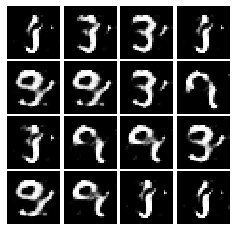

Epoch: 9, Iter: 4350, D: 0.08955, G:4.208


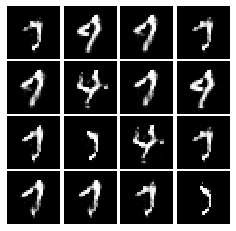

Epoch: 9, Iter: 4400, D: 0.3816, G:5.316


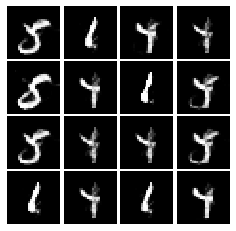

Epoch: 9, Iter: 4450, D: 3.72, G:1.67


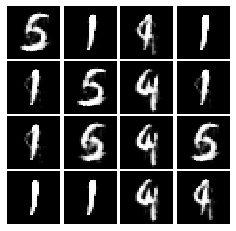

Epoch: 9, Iter: 4500, D: 0.4352, G:3.531


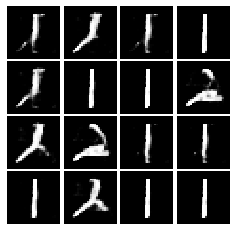

Epoch: 9, Iter: 4550, D: 0.2193, G:4.043


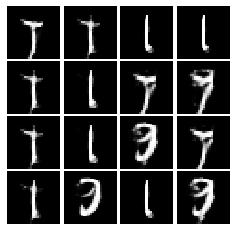

Epoch: 9, Iter: 4600, D: 0.4032, G:6.11


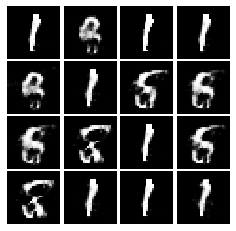

Epoch: 9, Iter: 4650, D: 0.1551, G:5.846


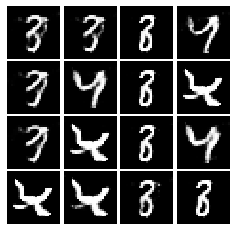

Final images


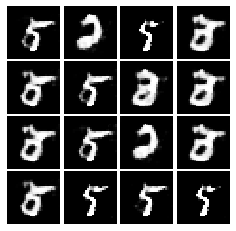

Wall time: 5min 43s


In [25]:
%%time

# Make the discriminator
D = discriminator()

# Make the generator
G = generator()

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver, G_solver = get_solvers()

# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, num_epochs=10)